In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from IPython.display import display
import statsmodels.api as sm
from sklearn import svm
import sklearn
import pickle
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import KFold
plt.rcParams.update({'font.size': 14}) # setting plots font size for clarity
print("Imported Necessary libs")

Imported Necessary libs


## Our goal is to build a model that predicts the service period of the employee before joining based on:
- **Nationality**
- **Job**
- **Joining age**
- **martial status**
- **qualification**

In [2]:
# reading data file
df_main = pd.read_csv(r"D:\Work\Products Databses\personnel\Notebooks\Application of course\New folder (2)\Exit_Analysis\Descriptive_Analysis_2\full_exit_data_cleaned.csv")

In [3]:
df_main.head()

,leave,nat,dept,job,join,martial_status,birth_date,qualification,service,join_age
0,2012-03-10,Nepalese,Consumer Products,Merchandiser,2008-05-03,Single,1986-01-29,NaN,3.854795,22.273973
1,2012-05-09,Filipino,Consumer Products,Assistant Sales Executive,2002-07-20,Married,1978-08-20,NaN,9.810959,23.931507
2,2012-05-11,Nepalese,Consumer Products,Merchandiser,2010-05-08,Single,1985-10-13,NaN,2.010959,24.583562
3,2012-06-12,Nepalese,Home Appliances Service Center,Helper,2007-03-12,Single,1987-12-01,NaN,5.257534,19.290411
4,2012-07-10,Nepalese,Consumer Electronics & Home Appliances,Merchandiser,2008-01-04,Single,1982-06-08,NaN,4.517808,25.591781


In [4]:
# exploring dataframe
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   leave           863 non-null    object 
 1   nat             863 non-null    object 
 2   dept            863 non-null    object 
 3   job             863 non-null    object 
 4   join            863 non-null    object 
 5   martial_status  863 non-null    object 
 6   birth_date      863 non-null    object 
 7   qualification   719 non-null    object 
 8   service         863 non-null    float64
 9   join_age        863 non-null    float64
dtypes: float64(2), object(8)
memory usage: 67.5+ KB


As we notice that there are some missing values in qualification column.  
We can remove them, however we do not want to lose data as the dataset is already small.  
Thus, we can try to use decision tree to predict the missing values in qualification columns

### **Firstly:** We need to prepare the data
- There are a lot of jobs so, if we want to use the job as a value to predict service period, we should limit this to the top 10 jobs for higher accuracy.
- Convert categorical to dummy values


In [5]:
df_main.job.value_counts()[:10]

Merchandiser              189
Helper                     61
Sales Executive            49
Driver                     40
Technician                 33
Asst Technician            24
Senior Sales Executive     22
Warehouse Asst             20
Van Salesman               20
Technician - Air Cons      18
Name: job, dtype: int64

In [6]:
# creating dataframe for the top 10 common jobs in the file as we have a lot
df_top_10_jobs = df_main[(df_main["job"] == "Merchandiser") | (df_main["job"] == "Driver") | (df_main["job"] == "Helper") | (df_main["job"] == "Sales Executive") | (df_main["job"] == "Technician") | (df_main["job"] == "Technician - Air Cons") | (df_main["job"] == "Van Salesman") | (df_main["job"] == "Assistant Sales Executive") | (df_main["job"] == "Senior Sales Executive") | (df_main["job"] == "Senior Technician")]

In [7]:
df_dums = pd.get_dummies(df_top_10_jobs[["nat","dept","job","martial_status"]])

In [8]:
df_dt_2 = df_dums.join(df_top_10_jobs[["join_age","service","qualification"]])
df_dt_2.head()

,nat_Bangladeshi,nat_Egyptian,nat_Filipino,nat_Indian,nat_Jordanian,nat_Kenyan,nat_Moroccan,nat_Nepalese,nat_Pakistani,nat_Sri Lankan,...,job_Technician,job_Technician - Air Cons,job_Van Salesman,martial_status_Divorced,martial_status_Married,martial_status_Single,martial_status_Widow,join_age,service,qualification
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,22.273973,3.854795,NaN
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,23.931507,9.810959,NaN
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,24.583562,2.010959,NaN
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,19.290411,5.257534,NaN
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,25.591781,4.517808,NaN


In [9]:
# standarizing the joining age
scaler = StandardScaler()
df_dt_2["join_age_scaled"] = scaler.fit_transform(df_dt_2[["join_age"]])

In [10]:
# finding the mean and std of the scaler
scaler.mean_, scaler.scale_

(array([28.17160648]), array([6.1953539]))

In [11]:
# creating dictionary of the qualification column values
qual_dict = {"Primary School":1, "High School":2, "Diploma":3,"Bachelors":4, "Masters":5}
df_dt_2.qualification.replace(qual_dict, inplace=True)

In [12]:
# excluding our missing qualification rows
df_dt_no_null = df_dt_2[df_dt_2["qualification"].isna()==False].reset_index(drop=True)
df_dt_no_null.head()

,nat_Bangladeshi,nat_Egyptian,nat_Filipino,nat_Indian,nat_Jordanian,nat_Kenyan,nat_Moroccan,nat_Nepalese,nat_Pakistani,nat_Sri Lankan,...,job_Technician - Air Cons,job_Van Salesman,martial_status_Divorced,martial_status_Married,martial_status_Single,martial_status_Widow,join_age,service,qualification,join_age_scaled
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,31.578082,7.131507,4.0,0.549844
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,23.468493,2.235616,2.0,-0.759136
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,26.769863,4.186301,2.0,-0.226257
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,28.619178,5.947945,2.0,0.072243
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,31.268493,6.810959,2.0,0.499872


In [13]:
# creating X & y for fitting the model
X = df_dt_no_null[df_dt_no_null.columns[(df_dt_no_null.columns != "qualification")]]
y = df_dt_no_null["qualification"]

In [14]:
# splitting the date into two parts 80%, 20%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=44)

In [18]:
# fitting support vector machine model
SVM_model = svm.SVC().fit(X_train, y_train)

C:\Users\g_rimoun\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [19]:
# predicting the values of the test set
y_hat = SVM_model.predict(X_test)

In [20]:
# printing the classificaiton report to show some statistics about model performance
print(sklearn.metrics.classification_report(y_test,y_hat))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.82      1.00      0.90        62
         3.0       0.00      0.00      0.00         4
         4.0       0.00      0.00      0.00         6
         5.0       0.00      0.00      0.00         3

    accuracy                           0.82        76
   macro avg       0.16      0.20      0.18        76
weighted avg       0.67      0.82      0.73        76



C:\Users\g_rimoun\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
# fitting decision tree classifier
dt_model = tree.DecisionTreeClassifier().fit(X_train, y_train)

In [22]:
# printing the classificaiton report to show some statistics about model performance
print(sklearn.metrics.classification_report(y_test,dt_model.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.93      0.87      0.90        62
         3.0       0.20      0.25      0.22         4
         4.0       0.30      0.50      0.37         6
         5.0       1.00      0.33      0.50         3

    accuracy                           0.78        76
   macro avg       0.49      0.39      0.40        76
weighted avg       0.83      0.78      0.80        76



It sounds like SVM has higher accuracy to predict than decision tree, so we will use SVM to predict the missing values

In [23]:
# we create a dataset that includes all missing values of qualification column
df_qual_null = df_dt_2[df_dt_2["qualification"].isna()==True].reset_index(drop=True)

In [24]:
# we predict the missing qualification values
real_X = df_qual_null[df_qual_null.columns[(df_qual_null.columns != "qualification")]]
predicted_qual = SVM_model.predict(real_X)

In [25]:
# replacing the values with our prediction to make the dataset full and ready
df_dt_2.loc[df_dt_2["qualification"].isna()==True, "qualification"] = predicted_qual

In [26]:
# we drop the joining aged as we have it in its scaled form
df_dt_2.drop("join_age", axis=1, inplace=True)

Now we have our data ready for linear regression so we will save this dataframe in a CSV file for easier access next times

In [27]:
# saving the dataframe to a CSV file
df_dt_2.to_csv("exit_top10_jobs_linear.csv")

In [28]:
# reading the dataframe 
df_linear = pd.read_csv("exit_top10_jobs_linear.csv", index_col=0)
df_linear.head()

,nat_Bangladeshi,nat_Egyptian,nat_Filipino,nat_Indian,nat_Jordanian,nat_Kenyan,nat_Moroccan,nat_Nepalese,nat_Pakistani,nat_Sri Lankan,...,job_Technician,job_Technician - Air Cons,job_Van Salesman,martial_status_Divorced,martial_status_Married,martial_status_Single,martial_status_Widow,service,qualification,join_age_scaled
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,3.854795,2.0,-0.951945
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,9.810959,2.0,-0.684400
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,2.010959,2.0,-0.579151
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,5.257534,2.0,-1.433525
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,4.517808,2.0,-0.416413


In [29]:
# getting a copy of our dataframe
df_linear_sm = df_linear.copy()

In [30]:
# adding intercept value
df_linear_sm.insert(0,"intercept",1)

Before fitting the model we will remove one column of each variable from the dummy columns, so our matrix become full ranked

we will remove:
- Tunisian from nationalities
- Home Appliances Service Center from departments
- Helper from jobs
- Widow from martial status

In [31]:
# excluding the baseline columns
baseline_columns = df_linear_sm.columns[(df_linear_sm.columns!="service")& (df_linear_sm.columns!="nat_Tunisian")& (df_linear_sm.columns!="dept_Home Appliances Service Center")& (df_linear_sm.columns!="job_Helper")& (df_linear_sm.columns!="martial_status_Widow")]

In [32]:
baseline_columns

Index(['intercept', 'nat_Bangladeshi', 'nat_Egyptian', 'nat_Filipino',
       'nat_Indian', 'nat_Jordanian', 'nat_Kenyan', 'nat_Moroccan',
       'nat_Nepalese', 'nat_Pakistani', 'nat_Sri Lankan',
       'dept_Consumer Electronics & Home Appliances', 'dept_Consumer Products',
       'dept_General Products', 'dept_HR & Administration', 'dept_Logistics',
       'dept_Office Equipment & Business Solutions',
       'dept_Office Equipment Service Center',
       'dept_Office Furniture & Furnishing', 'job_Assistant Sales Executive',
       'job_Driver', 'job_Merchandiser', 'job_Sales Executive',
       'job_Senior Sales Executive', 'job_Senior Technician', 'job_Technician',
       'job_Technician - Air Cons', 'job_Van Salesman',
       'martial_status_Divorced', 'martial_status_Married',
       'martial_status_Single', 'qualification', 'join_age_scaled'],
      dtype='object')

In [33]:
# fitting linear model using stats_models
lm = sm.OLS(df_linear_sm["service"], df_linear_sm[baseline_columns]).fit()

In [34]:
# printing the model report
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                service   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     8.349
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           6.39e-29
Time:                        08:38:29   Log-Likelihood:                -1297.0
No. Observations:                 462   AIC:                             2660.
Df Residuals:                     429   BIC:                             2796.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
intercept                                       9.1603      5.342      1.715      0.087      -1.339      19.660
nat_Bangladeshi                                16.6381      5.314      3.131      0.002       6.194      27.082
nat_Egyptian                                   -6.2868      3.524     -1.784      0.075     -13.213       0.640
nat_Filipino                                    0.8418      3.103      0.271      0.786      -5.257       6.940
nat_Indian                                      1.2079      3.102      0.389      0.697      -4.890       7.305
nat_Jordanian                                  -3.9240      5.375     -0.730      0.466     -14.488       6.640
nat_Kenyan                                     -2.7703      3.383     -0.819      0.413      -9.419       3.878
nat_Moroccan                                   -5.1146      5.320     -0.961      0.337     -15.570       5.341
nat_Nepalese                                   -1.5326      3.086     -0.497      0.620      -7.599       4.534
nat_Pakistani                                  11.4983      4.368      2.633      0.009       2.914      20.083
nat_Sri Lankan                                 -2.3288      3.095     -0.752      0.452      -8.413       3.755
dept_Consumer Electronics & Home Appliances    -0.4383      2.092     -0.209      0.834      -4.551       3.674
dept_Consumer Products                          0.4829      2.061      0.234      0.815      -3.569       4.535
dept_General Products                           2.3295      2.146      1.085      0.278      -1.889       6.548
dept_HR & Administration                        7.7496      2.226      3.481      0.001       3.374      12.125
dept_Logistics                                 -0.2327      1.206     -0.193      0.847      -2.602       2.137
dept_Office Equipment & Business Solutions     -1.3627      2.507     -0.544      0.587      -6.290       3.565
dept_Office Equipment Service Center           -3.7300      1.220     -3.056      0.002      -6.129      -1.331
dept_Office Furniture & Furnishing              5.4311      2.254      2.409      0.016       1.000       9.862
job_Assistant Sales Executive                  -1.3368      2.163     -0.618      0.537      -5.589       2.915
job_Driver                                      1.0613      0.964      1.100      0.272      -0.834       2.957
job_Merchandiser                               -1.3944      1.872     -0.745      0.457      -5.074       2.285
job_Sales Executive                            -0.3127      1.959     -0.160      0.873      -4.163       3.538
job_Senior Sales Executive                      3.4567      2.133      1.621      0.106      -0.736       7.649
job_Senior Technician                           9.3220     

**From the summary we notice that R squared is really low, however we have many values that represent their P-value indicates that they are statistically significant.**
**Another thing worth mentioning here that the baseline is around 9, which is quite high service**

### Based on the previous summary we can change the labeling and use categorical codes instead of dummy to add a complexity to our model after removing the outliers

In [35]:
# creating a dataframe to test the dataset without manipulation
df_linear_2 = df_top_10_jobs.copy()
df_linear_2.head()

,leave,nat,dept,job,join,martial_status,birth_date,qualification,service,join_age
0,2012-03-10,Nepalese,Consumer Products,Merchandiser,2008-05-03,Single,1986-01-29,NaN,3.854795,22.273973
1,2012-05-09,Filipino,Consumer Products,Assistant Sales Executive,2002-07-20,Married,1978-08-20,NaN,9.810959,23.931507
2,2012-05-11,Nepalese,Consumer Products,Merchandiser,2010-05-08,Single,1985-10-13,NaN,2.010959,24.583562
3,2012-06-12,Nepalese,Home Appliances Service Center,Helper,2007-03-12,Single,1987-12-01,NaN,5.257534,19.290411
4,2012-07-10,Nepalese,Consumer Electronics & Home Appliances,Merchandiser,2008-01-04,Single,1982-06-08,NaN,4.517808,25.591781


In [36]:
# reversing the qualification dictionary to replace their numbers with the right values
qual_inverted_dict = dict(map(reversed, qual_dict.items()))
qual_inverted_dict

{1: 'Primary School',
 2: 'High School',
 3: 'Diploma',
 4: 'Bachelors',
 5: 'Masters'}

In [37]:
# replacing the missing values with the predicted ones
df_linear_2.loc[df_linear_2["qualification"].isna()==True,["qualification"]] = predicted_qual

In [38]:
# replacing the numerical values with their categories
df_linear_2["qualification"] = df_linear_2["qualification"].replace(qual_inverted_dict)

In [39]:
# checking the replacments
df_linear_2.qualification.value_counts()

High School       364
Bachelors          55
Diploma            31
Masters             7
Primary School      5
Name: qualification, dtype: int64

In [40]:
# dropping unncessary columns
df_linear_2.drop(["leave","birth_date","join"], axis=1, inplace=True)

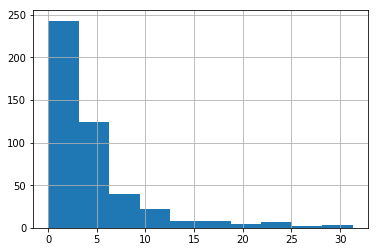

In [41]:
# showing histogram of service period
df_linear_2["service"].hist()

the number of employees which served more than ten years is low compared to employees who served less, so we can limit our values with 10 years as maximum of service period

In [42]:
# excluding service period with 10 years or more
df_linear_2 = df_linear_2[df_linear_2["service"]<=10]

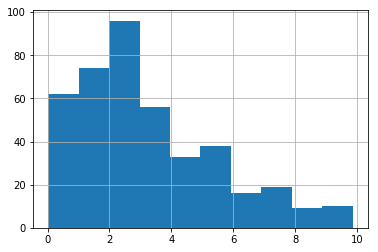

In [43]:
# service after excluding 10 years or more values
df_linear_2["service"].hist()

In [44]:
# checking the dataset after the changes
df_linear_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413 entries, 0 to 859
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   nat             413 non-null    object 
 1   dept            413 non-null    object 
 2   job             413 non-null    object 
 3   martial_status  413 non-null    object 
 4   qualification   413 non-null    object 
 5   service         413 non-null    float64
 6   join_age        413 non-null    float64
dtypes: float64(2), object(5)
memory usage: 25.8+ KB


we will convert string columns to categories to get their codes

In [45]:
# converting categorical columns from string to CATEGORY data type 
for i in df_linear_2.columns[(df_linear_2.columns!="service")&(df_linear_2.columns!="join_age")]: 
    df_linear_2[i] = df_linear_2[i].astype('category')

In [46]:
# checking the dataset after the changes
df_linear_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413 entries, 0 to 859
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   nat             413 non-null    category
 1   dept            413 non-null    category
 2   job             413 non-null    category
 3   martial_status  413 non-null    category
 4   qualification   413 non-null    category
 5   service         413 non-null    float64 
 6   join_age        413 non-null    float64 
dtypes: category(5), float64(2)
memory usage: 13.1 KB


In [47]:
# creating an empty dataframe and saving the codes of the categories
df_linear_3 = pd.DataFrame()

# looping through columns to convert the categories to a numerical data frame 
for i in df_linear_2.columns[:5]:
    df_linear_3[i] = df_linear_2[i].cat.codes
    
# checking the generated dataframe
df_linear_3.head()

,nat,dept,job,martial_status,qualification
0,6,1,3,1,2
1,1,1,0,0,2
2,6,1,3,1,2
3,6,4,2,1,2
4,6,0,3,1,2


In [48]:
# joining the joining age and service years
df_linear_3 = df_linear_3.join(df_linear_2[["join_age","service"]])

In [49]:
# checking the changes
df_linear_3.head()

,nat,dept,job,martial_status,qualification,join_age,service
0,6,1,3,1,2,22.273973,3.854795
1,1,1,0,0,2,23.931507,9.810959
2,6,1,3,1,2,24.583562,2.010959
3,6,4,2,1,2,19.290411,5.257534
4,6,0,3,1,2,25.591781,4.517808


In [50]:
# adding intercept column
df_linear_3.insert(0,"intercept",1)

In [51]:
# fitting the linear regression model
lm2 = sm.OLS(df_linear_3["service"], df_linear_3[df_linear_3.columns[df_linear_3.columns!="service"]]).fit()

In [52]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                service   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     4.356
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           0.000281
Time:                        08:39:52   Log-Likelihood:                -908.69
No. Observations:                 413   AIC:                             1831.
Df Residuals:                     406   BIC:                             1860.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          7.3044      0.894      8.172      0.000       5.547       9.062
nat               -0.0138      0.062     -0.222      0.824      -0.136       0.109
dept               0.0112      0.049      0.229      0.819      -0.085       0.107
job                0.0203      0.056      0.365      0.715      -0.089       0.129
martial_status    -0.7607      0.265     -2.870      0.004      -1.282      -0.240
qualification     -0.3289      0.171     -1.927      0.055      -0.664       0.007
join_age          -0.1116      0.024     -4.662      0.000      -0.159      -0.065
==============================================================================
Omnibus:                       49.124   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.618
Skew:                           0.945   Prob(JB):                     1.53e-14
Kurtosis:                       3.353   Cond. No.                         245.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**In this model our R squared got lower than the previous model, so we will use the previous model to create our linear model with sklearn.**

In [53]:
# excluding the service more than 10 years
df_linear_sk = df_linear[df_linear["service"]<=10]
df_linear_sk.head()

,nat_Bangladeshi,nat_Egyptian,nat_Filipino,nat_Indian,nat_Jordanian,nat_Kenyan,nat_Moroccan,nat_Nepalese,nat_Pakistani,nat_Sri Lankan,...,job_Technician,job_Technician - Air Cons,job_Van Salesman,martial_status_Divorced,martial_status_Married,martial_status_Single,martial_status_Widow,service,qualification,join_age_scaled
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,3.854795,2.0,-0.951945
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,9.810959,2.0,-0.684400
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,2.010959,2.0,-0.579151
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,5.257534,2.0,-1.433525
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,4.517808,2.0,-0.416413


In [54]:
# defining model X, Y
X_linear = df_linear_sk[df_linear_sk.columns[df_linear_sk.columns!="service"]]
y_linear = df_linear_sk["service"]

In [55]:
# splitting the dataset
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_linear,y_linear,test_size=0.2,random_state=44)

In [56]:
# fitting the model using sklearn lib
lm3 = sklearn.linear_model.LinearRegression()
lm3.fit(X_train_l, y_train_l)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
# predicting the values
yh_lm3 = lm3.predict(X_test_l)

In [58]:
# checking the r2 score
sklearn.metrics.r2_score(y_test_l, yh_lm3)

0.20982437761355455

In [59]:
# checking squared mean error
np.sqrt(sklearn.metrics.mean_squared_error(y_test_l, yh_lm3))

1.7856600778734717

### We still have r_squared small value and we have high squared mean error, However we can use the model to make initial predictions $\pm$ **1.79**  
### Adding other features like salary and increasing the data may improve the model performance

## For simplicity we will build a model based on the second dataset without manipulation as in both cases the accuracy is not high

In [60]:
# creating a final dataframe to fit a linear model for illustration purposes
df_final_linear_model = df_linear_3[['nat', 'dept', 'job', 'martial_status', 'join_age', 'qualification' ,'service']]

In [61]:
# splitting dataset
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(df_final_linear_model[df_final_linear_model.columns[df_final_linear_model.columns!='service']],df_final_linear_model["service"],test_size=0.2,random_state=44)

In [62]:
# fitting the linear model
lmf = sklearn.linear_model.LinearRegression()
lmf.fit(X_train_f, y_train_f)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
# checking the score
sklearn.metrics.r2_score(y_test_f, lmf.predict(X_test_f))

0.04167482976099912

In [64]:
# checking squared mean error
np.sqrt(sklearn.metrics.mean_squared_error(y_test_f, lmf.predict(X_test_f)))

1.9664976106704435

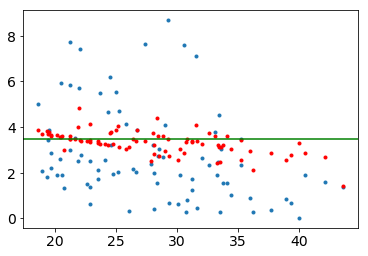

In [103]:
plt.plot(X_test_f['join_age'], y_test_f,linestyle='none', marker='.')
plt.plot(X_test_f['join_age'],lmf.predict(X_test_f), linestyle='none', marker='.', color='red')
plt.axhline(3.5, color='g')

In [119]:
# saving the model into a pickle format to use for the Application
pickle.dump(lmf, open("linear model.sav", 'wb'))

## <u>Conclusion:</u>
### We have created a simple model to evaluate the approximate service period of an employee before joining. However, there are some other factors to consider as folows:
- **The data that we have is not enough to generate a model with a high accuracy and we may require more data like salary at joining and any information that may help us like if the employee resigned or dismissed.**  
- **Therefore, having explored the possbilites that mey result of using this data accurately will help the company to select employees that they meet the business needs.**  
- **Another factor that may help which is the skills that employee have at joining. Considering a factor like this may help determining the service period perceisly and to consider the employees based on their potential as well.**  
- **Another use case for the data if they have the column, resigned or dismissed, it may show patterns in specific jobs.**